# Time Series Analysis

## Import Libraries

In [78]:
import os
import numpy as np
import pandas as pd
import datetime as dt

from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.tsa.deterministic import Fourier, Seasonality, TimeTrend

from pathlib import Path
from warnings import simplefilter
# ignore warnings to clean up output cells
simplefilter("ignore")  

# visualization
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns

# to print all the outputs in the cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# to show warnings only once:
import warnings; warnings.filterwarnings(action='once')

## Some additional settings

In [79]:
# adjusting columns width & number of chars
pd.set_option('display.width', 1200)
pd.set_option('max_colwidth', 500)

# set pandas max columns and rows to print
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

# settings for Vizs
plt.style.use("dark_background")
# plt.style.use("seaborn-whitegrid")

plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

In [80]:
pio.templates.default = "simple_white"

px.defaults.template = "plotly_dark"
px.defaults.color_continuous_scale = px.colors.sequential.Blackbody
px.defaults.width = 800
px.defaults.height = 500
color_discrete_sequence=px.colors.sequential.Oryel

## Linear Regression with time series

`Download the data`

In [81]:
source_dir = './reports/'

# files to download:
file_users_daily = 'at_users_daily.csv'

In [82]:
users_daily = pd.read_csv(os.path.join(source_dir, file_users_daily)
                       ,parse_dates=['visit_date', 'week_start_monday', 'visit_month']
                    #    ,dtype={'device': 'category', 'source_id': 'int'}
                       )

In [83]:
df_users_daily = users_daily.copy()

In [84]:
df_users_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 20 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   visit_date                            364 non-null    datetime64[ns]
 1   dau                                   364 non-null    int64         
 2   sessions_count                        364 non-null    int64         
 3   orders_count                          364 non-null    int64         
 4   revenue_sum                           364 non-null    float64       
 5   session_duration_sec_sum              364 non-null    int64         
 6   is_new_user_sum                       364 non-null    int64         
 7   is_new_buyer_sum                      364 non-null    int64         
 8   n_buyers                              364 non-null    int64         
 9   diff_1st_visit_1st_purchase_mean_sec  363 non-null    float64       
 10  vi

In [85]:
df_users_daily = df_users_daily.rename(columns={'orders_count': 'orders', 'revenue_sum': 'revenue'})
df_users_daily.head()

,visit_date,dau,sessions_count,orders,revenue,session_duration_sec_sum,is_new_user_sum,is_new_buyer_sum,n_buyers,diff_1st_visit_1st_purchase_mean_sec,visit_weekday,weekday_num,visit_week_num,week_start_monday,visit_month,visit_year,num_sessions_per_user_mean,num_orders_per_user_mean,session_duration_sec_mean,conversion_rate_%
0,2017-06-01,605,678,96,249.62,305817,605,86,96,22654.0,Thursday,3,22,2017-05-29,2017-06-01,2017,1.12,0.16,451,14.16
1,2017-06-02,611,674,111,274.35,307055,564,97,111,19472.0,Friday,4,22,2017-05-29,2017-06-01,2017,1.10,0.18,455,16.47
2,2017-06-03,447,487,68,170.15,208159,411,58,68,23657.0,Saturday,5,22,2017-05-29,2017-06-01,2017,1.09,0.15,427,13.96
3,2017-06-04,481,521,66,145.63,219278,441,55,66,20034.0,Sunday,6,22,2017-05-29,2017-06-01,2017,1.08,0.14,420,12.67
4,2017-06-05,827,909,161,386.06,404334,746,140,161,23597.0,Monday,0,23,2017-06-05,2017-06-01,2017,1.10,0.19,444,17.71


In [86]:
df_dau = df_users_daily[['visit_date', 'dau', 'orders']].set_index('visit_date')
df_dau.head()

,dau,orders
visit_date,,
2017-06-01,605,96
2017-06-02,611,111
2017-06-03,447,68
2017-06-04,481,66
2017-06-05,827,161


### Linear Regression of DAU

`Time-step features for DAU`

In [87]:
df_dau['time'] = np.arange(len(df_dau.index))
df_dau = df_dau.reindex(columns=['time', 'dau', 'orders'])
df_dau.head()

,time,dau,orders
visit_date,,,
2017-06-01,0,605,96
2017-06-02,1,611,111
2017-06-03,2,447,68
2017-06-04,3,481,66
2017-06-05,4,827,161


Text(0.5, 1.0, 'Time plot of DAU (Daily Active Unique Users)')

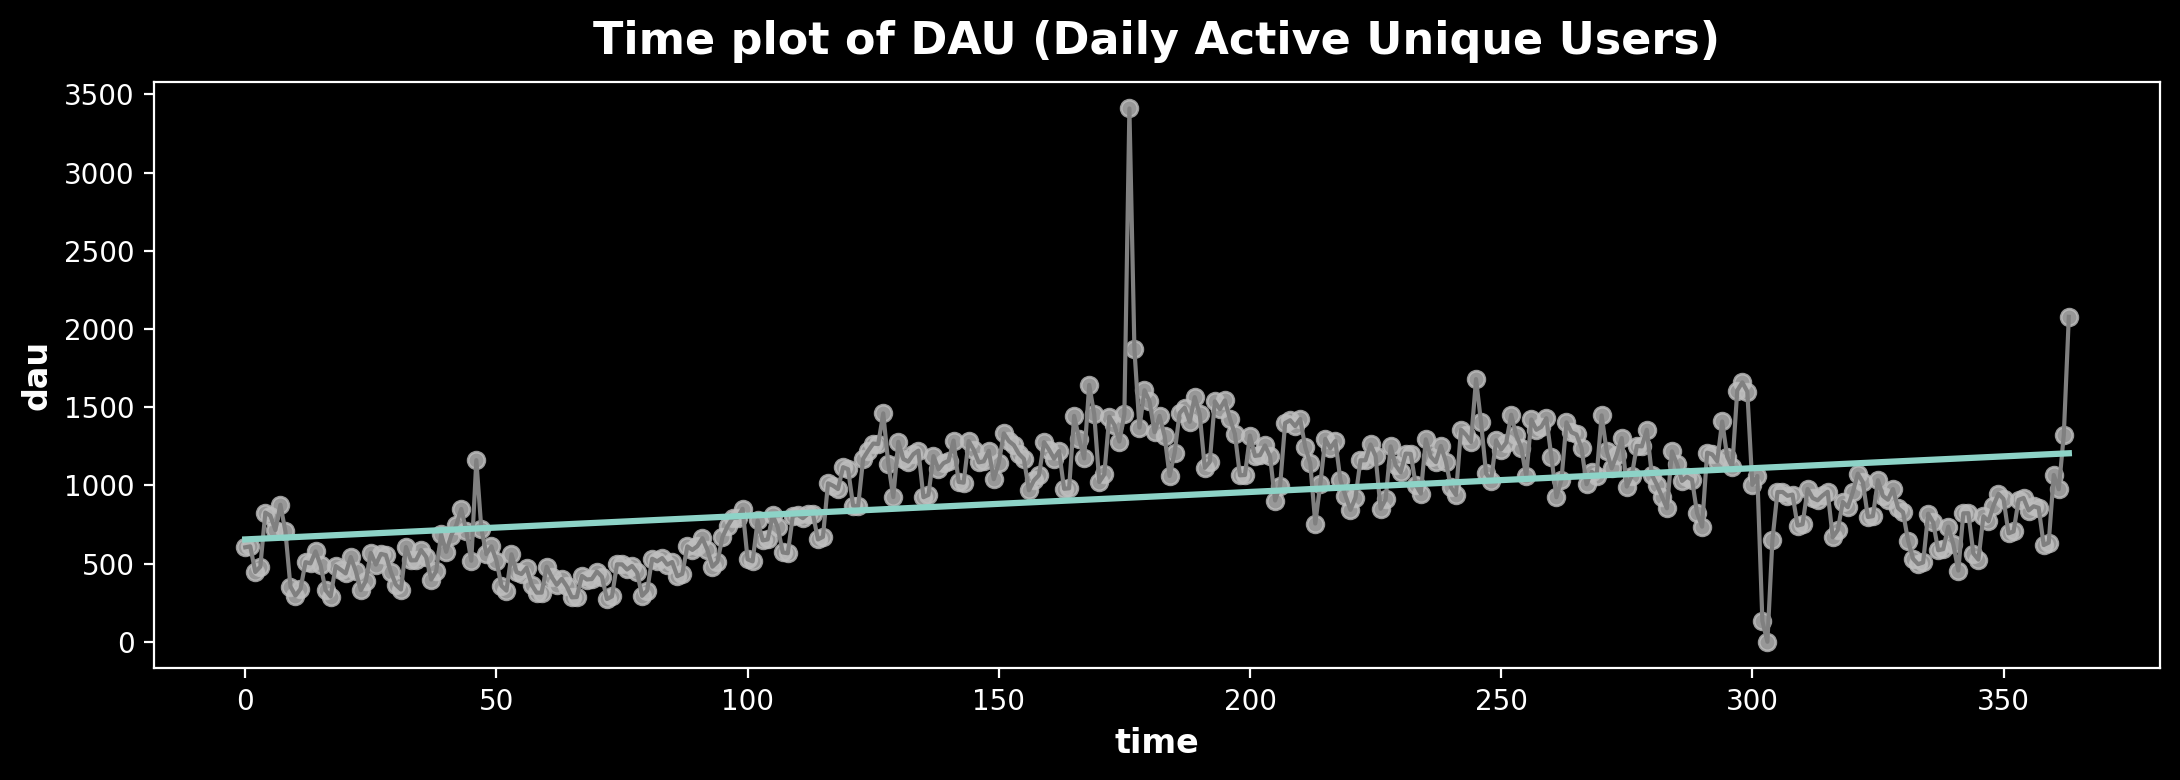

In [88]:
fig, ax = plt.subplots()
ax.plot('time', 'dau', data=df_dau, color='0.50')
ax = sns.regplot(x='time', y='dau', data=df_dau, ci=None, scatter_kws=dict(color='0.75'))
ax.set_title('Time plot of DAU (Daily Active Unique Users)')

`Lag features for DAU`

Linear regression with a lag feature produces the model:

target = weight * lag + bias

More generally, lag features let you model serial dependence.

In [89]:
df_dau['lag_dau'] = df_dau['dau'].shift(periods=1, fill_value=0).astype(int)
df_dau['lag_orders'] = df_dau['orders'].shift(periods=1, fill_value=0).astype(int)

df_dau.head()

,time,dau,orders,lag_dau,lag_orders
visit_date,,,,,
2017-06-01,0,605,96,0,0
2017-06-02,1,611,111,605,96
2017-06-03,2,447,68,611,111
2017-06-04,3,481,66,447,68
2017-06-05,4,827,161,481,66


Text(0.5, 1.0, 'Lag Plot of DAU (Daily Active Unique Users)')

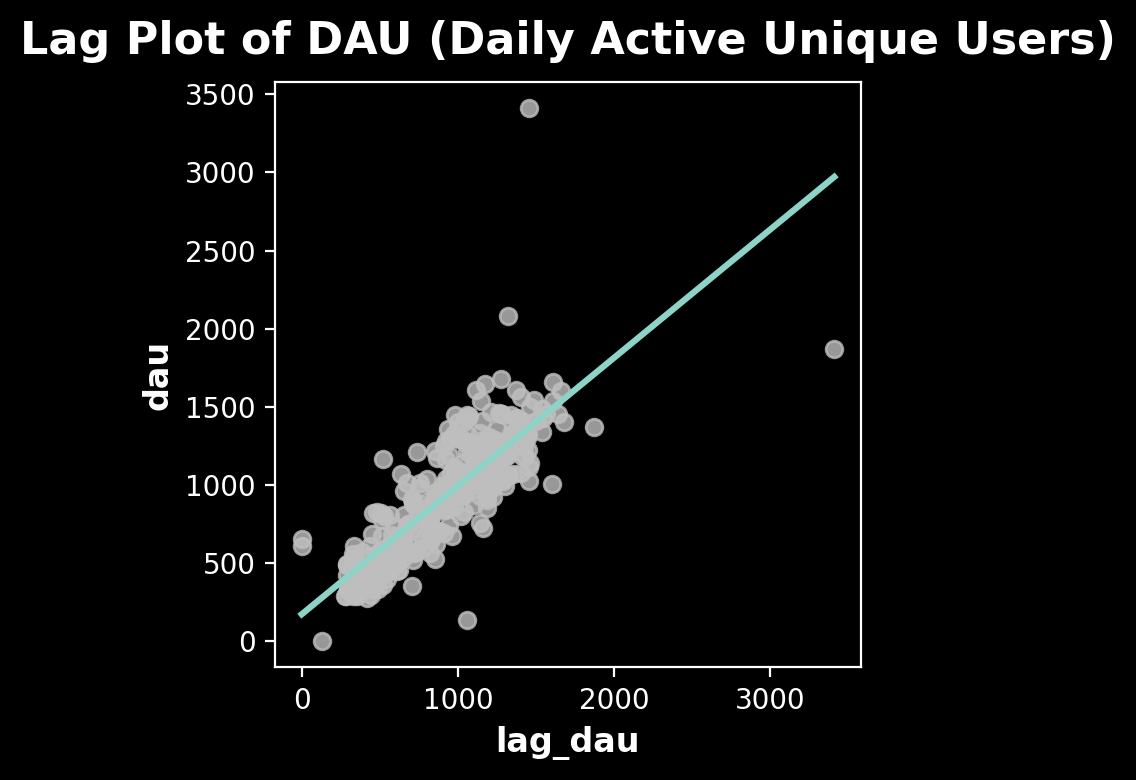

In [90]:
fig, ax = plt.subplots()
ax = sns.regplot(x='lag_dau', y='dau', data=df_dau, ci=None, scatter_kws=dict(color='0.75'))
ax.set_aspect('equal')
ax.set_title('Lag Plot of DAU (Daily Active Unique Users)')

`Linear Regression Model for DAU`

`The procedure for fitting a linear regression model follows the standard steps for scikit-learn.`

In [91]:
X_dau = df_dau.loc[:, ['time']] # feature
y_dau = df_dau.loc[:, 'dau'] # target value

# Train the model

model = LinearRegression()
model.fit(X_dau, y_dau)

# Store the fitted values as a time series with the same time index as
# the training data

y_pred_dau = pd.Series(model.predict(X_dau), index=X_dau.index)

LinearRegression()

Text(0.5, 1.0, 'Time Plot of Fitted Values of DAU (Daily Active Unique Users)')

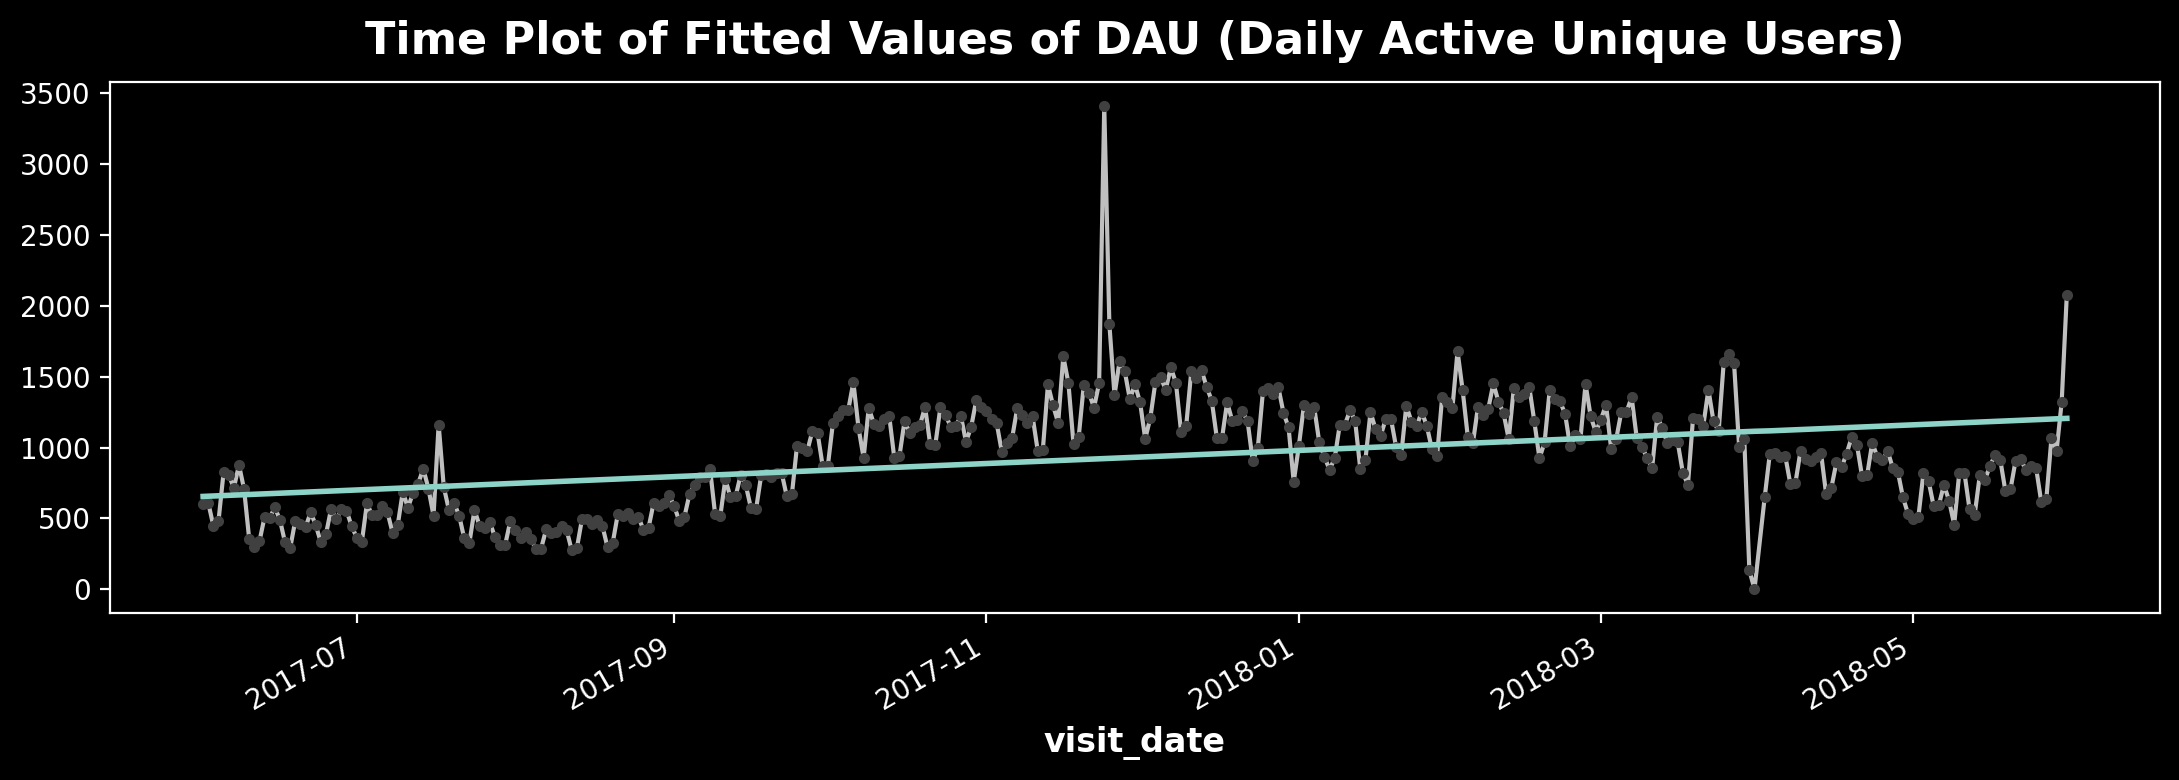

In [92]:
ax = y_dau.plot(**plot_params)
ax = y_pred_dau.plot(ax=ax, linewidth=2)
ax.set_title('Time Plot of Fitted Values of DAU (Daily Active Unique Users)')

In [93]:
X2 = df_dau.loc[:, ['lag_dau']]

# drop missing values in the feature set
X2.dropna(inplace=True)  

# create the target
y2 = df_dau.loc[:, 'dau']  

# drop corresponding values in target
y2, X2 = y2.align(X2, join='inner')  

model = LinearRegression()
model.fit(X2, y2)

y_pred2 = pd.Series(model.predict(X2), index=X2.index)

LinearRegression()

The lag plot shows us how well we were able to fit the relationship between the number DAU one day and the number the previous day.

Text(0, 0.5, 'dau')

Text(0.5, 0, 'lag_dau')

Text(0.5, 1.0, 'Lag Plot of Fitted Values of DAU (Daily Active Unique Users)')

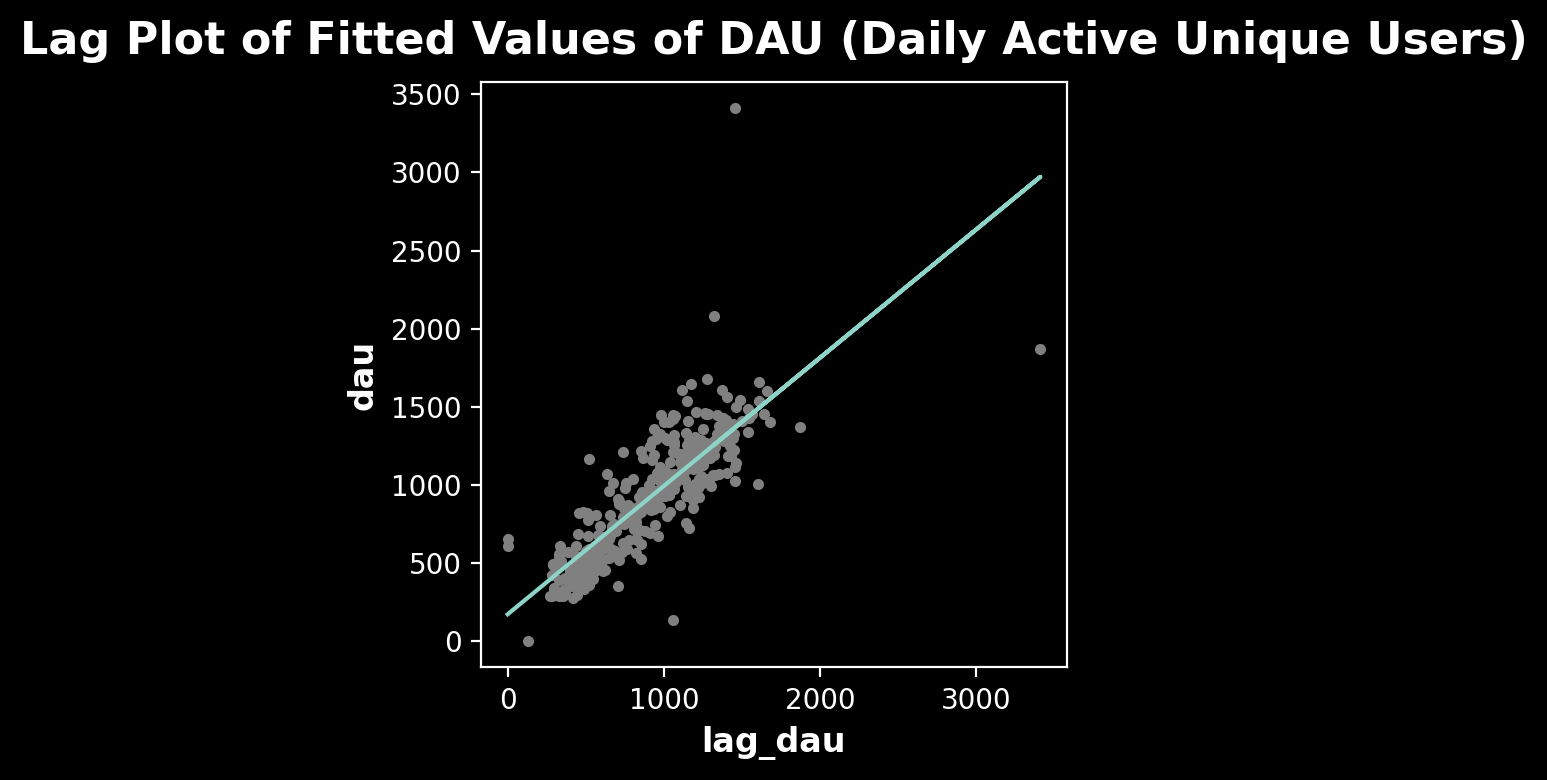

In [94]:
fig, ax = plt.subplots()
ax.plot(X2['lag_dau'], y2, '.', color='0.50')
ax.plot(X2['lag_dau'], y_pred2)
ax.set_aspect('equal')
ax.set_ylabel('dau')
ax.set_xlabel('lag_dau')
ax.set_title('Lag Plot of Fitted Values of DAU (Daily Active Unique Users)')

`The following time plot shows us how our forecasts now respond to the behavior of the series in the recent past`

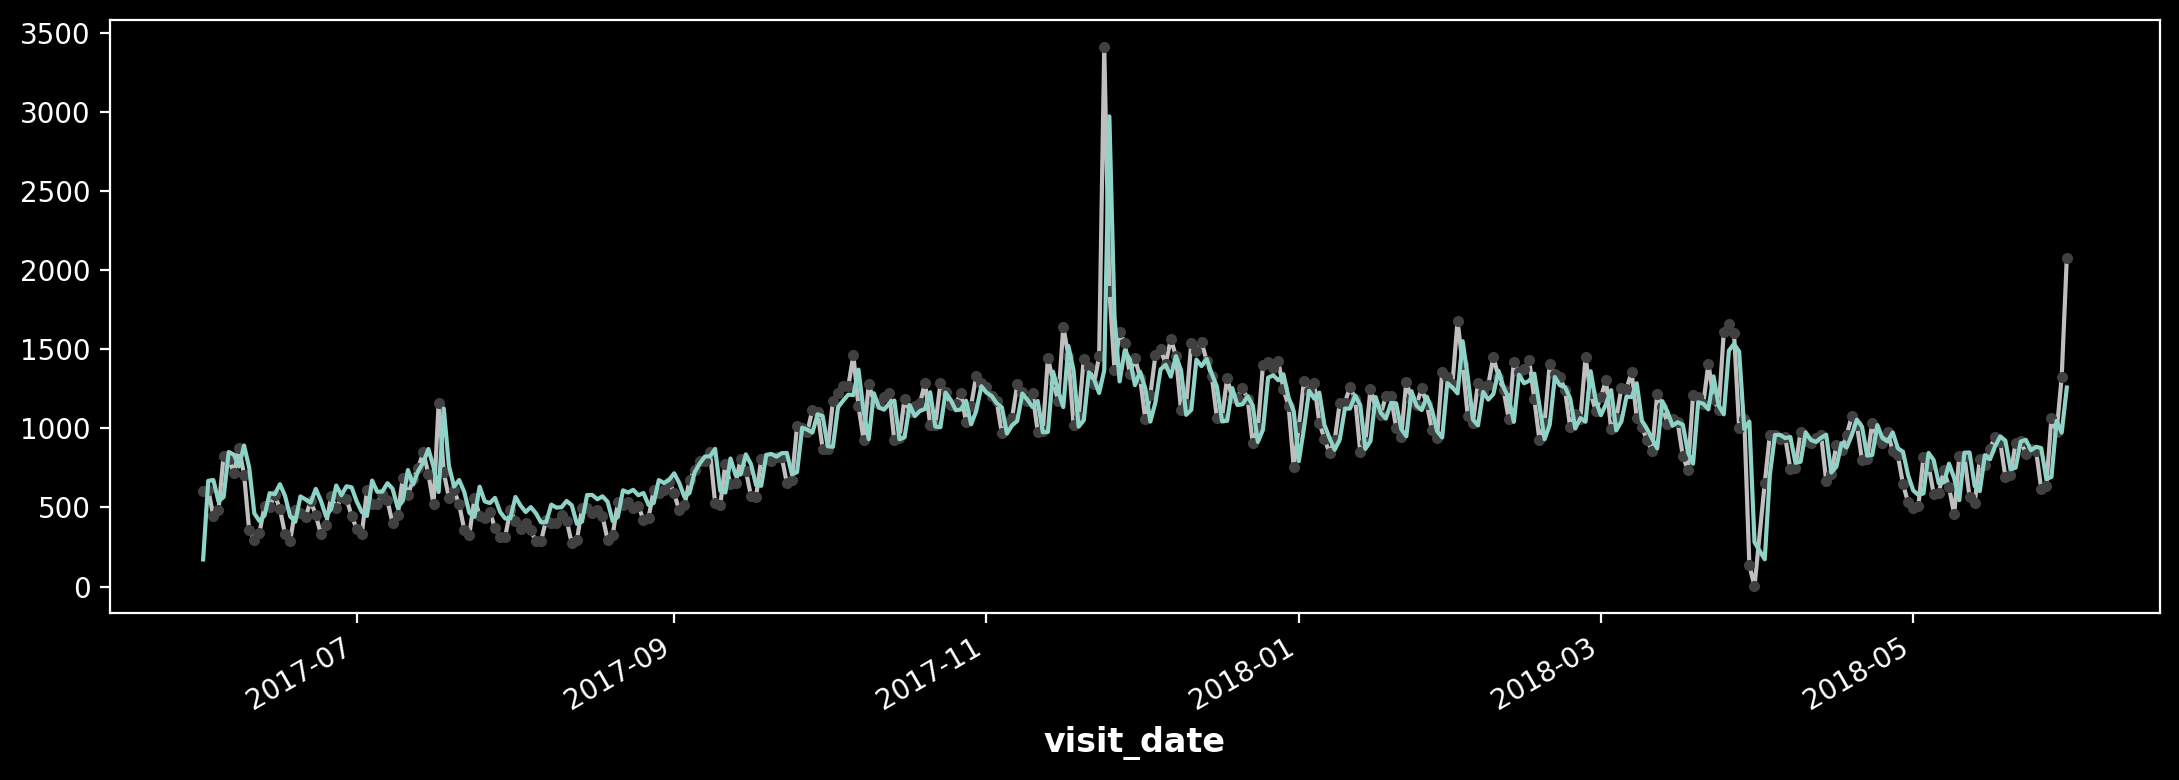

In [95]:
ax = y2.plot(**plot_params)
ax = y_pred2.plot()

### Linear Regression with Orders

`Time-step features for Orders`

Text(0.5, 1.0, 'Time plot of Number of Orders')

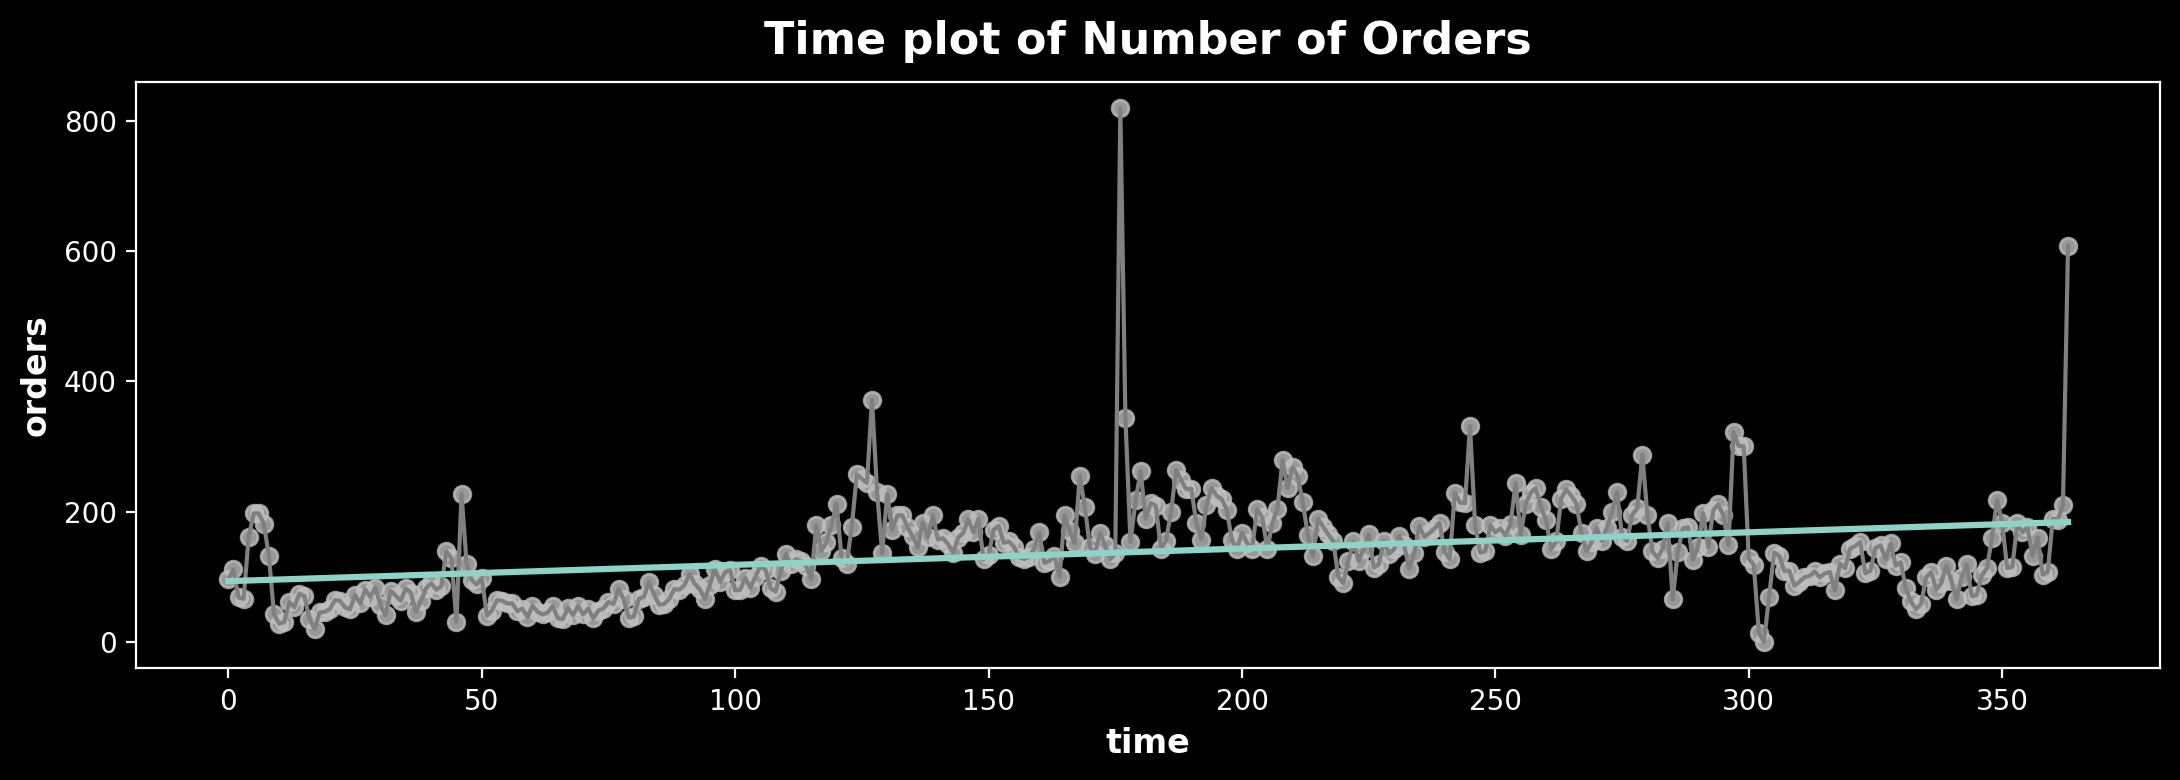

In [96]:
fig, ax = plt.subplots()
ax.plot('time', 'orders', data=df_dau, color='0.50')
ax = sns.regplot(x='time', y='orders', data=df_dau, ci=None, scatter_kws=dict(color='0.75'))
ax.set_title('Time plot of Number of Orders')

`Lag feature of order Numbers`

Text(0.5, 1.0, 'Lag Plot of Number of Orders')

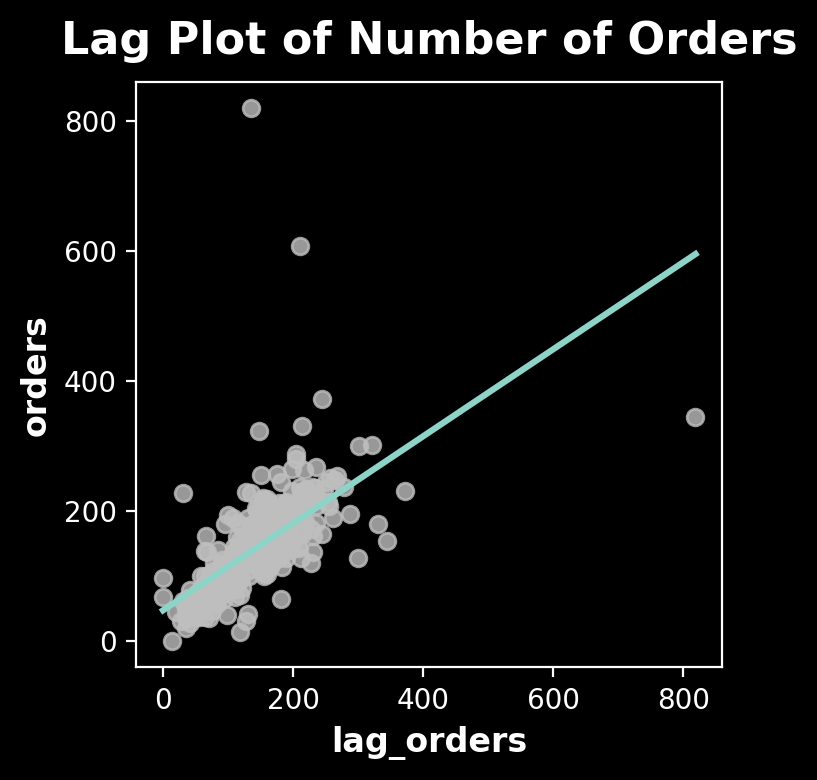

In [97]:
fig, ax = plt.subplots()
ax = sns.regplot(x='lag_orders', y='orders', data=df_dau, ci=None, scatter_kws=dict(color='0.75'))
ax.set_aspect('equal')
ax.set_title('Lag Plot of Number of Orders')

`Linear Regression Model for Orders`

In [98]:
X_orders = df_dau.loc[:, ['time']] # feature
y_orders = df_dau.loc[:, 'orders'] # target value

# Train the model

model = LinearRegression()
model.fit(X_orders, y_orders)

# Store the fitted values as a time series with the same time index as
# the training data

y_pred_orders = pd.Series(model.predict(X_orders), index=X_orders.index)

LinearRegression()

Text(0.5, 1.0, 'Time Plot of Fitted values of Number of Orders')

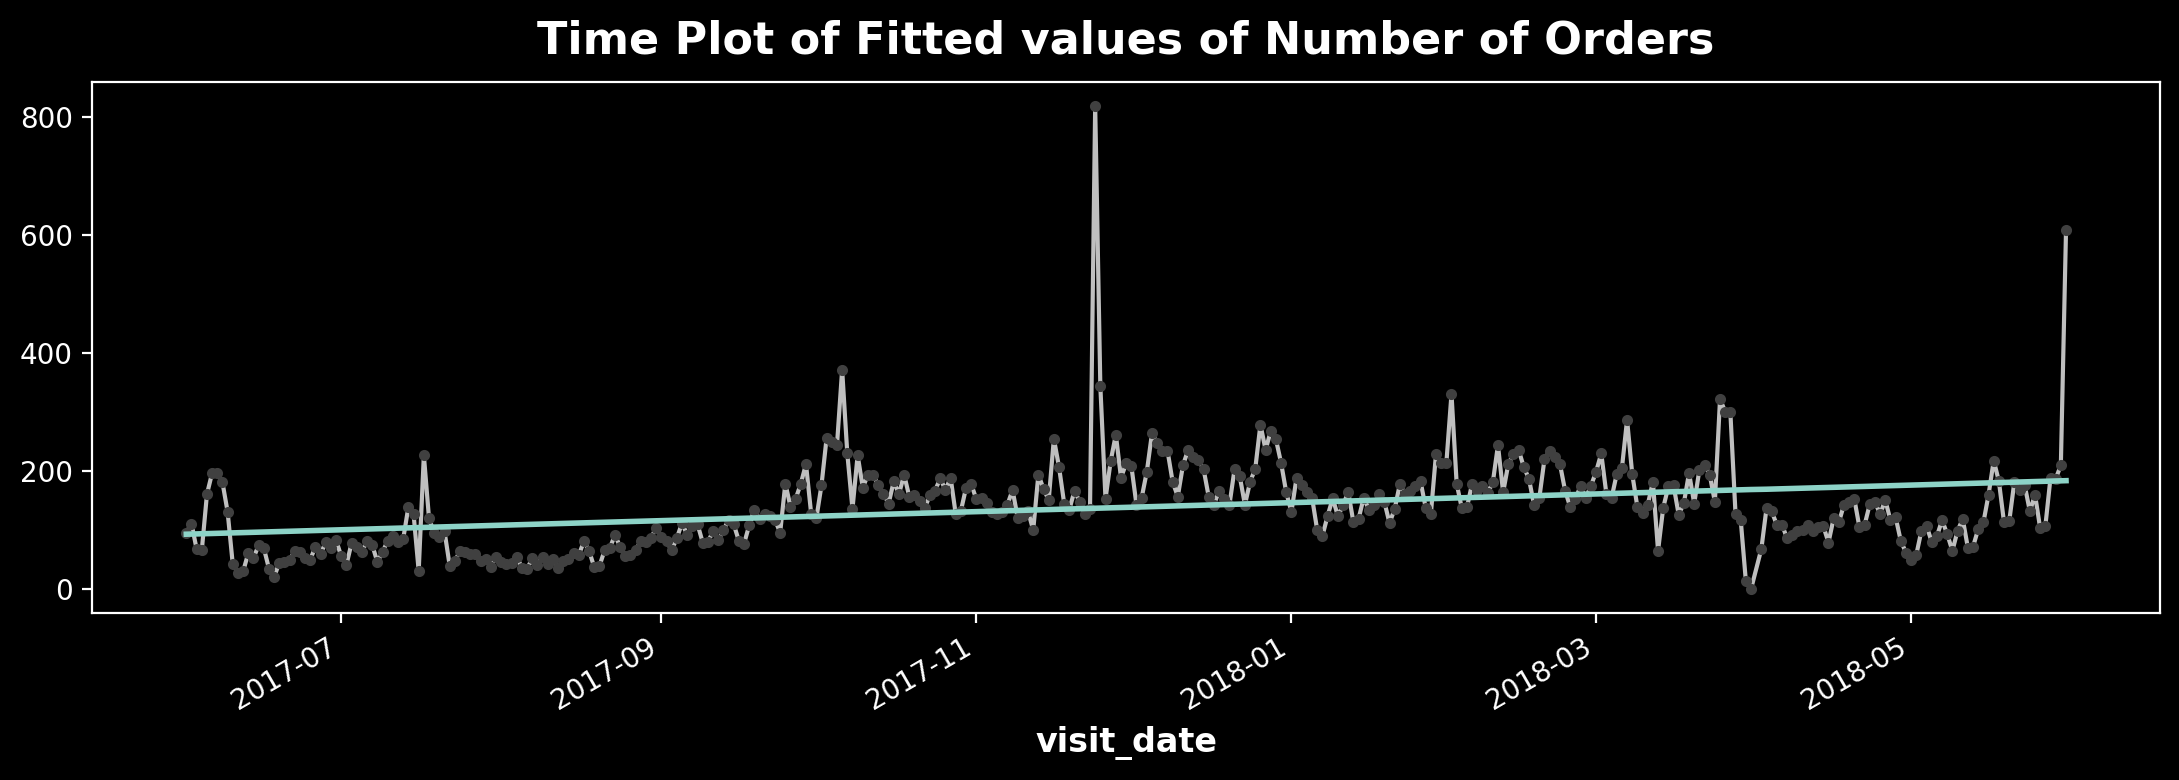

In [99]:
ax = y_orders.plot(**plot_params)
ax = y_pred_orders.plot(ax=ax, linewidth=2)
ax.set_title('Time Plot of Fitted values of Number of Orders')

In [100]:
X2_orders = df_dau.loc[:, ['lag_orders']]

# drop missing values in the feature set
X2_orders.dropna(inplace=True)  

# create the target
y2_orders = df_dau.loc[:, 'orders']  

# drop corresponding values in target
y2_orders, X2_orders = y2_orders.align(X2_orders, join='inner')  

model = LinearRegression()
model.fit(X2_orders, y2_orders)

y_pred2_orders = pd.Series(model.predict(X2_orders), index=X2_orders.index)

LinearRegression()

Text(0, 0.5, 'orders')

Text(0.5, 0, 'lag_orders')

Text(0.5, 1.0, 'Lag Plot of Fitted Values of Number of Orders')

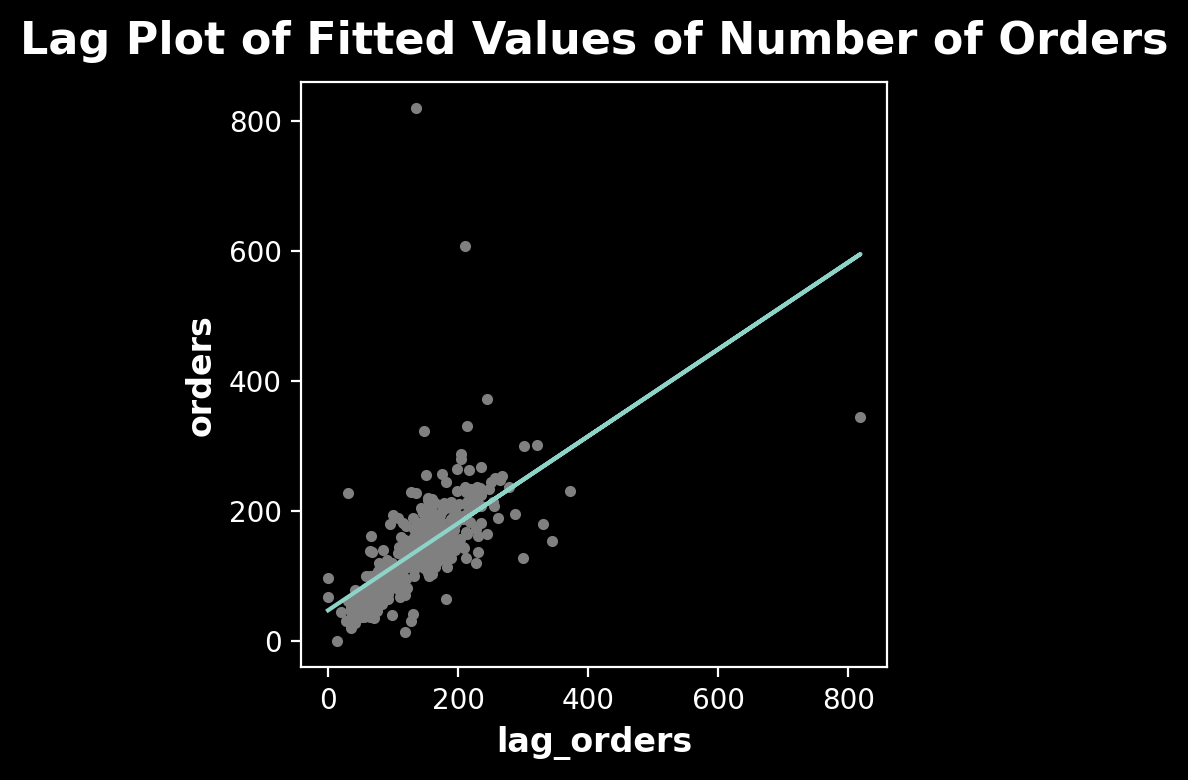

In [101]:
fig, ax = plt.subplots()
ax.plot(X2_orders['lag_orders'], y2_orders, '.', color='0.50')
ax.plot(X2_orders['lag_orders'], y_pred2_orders)
ax.set_aspect('equal')
ax.set_ylabel('orders')
ax.set_xlabel('lag_orders')
ax.set_title('Lag Plot of Fitted Values of Number of Orders')

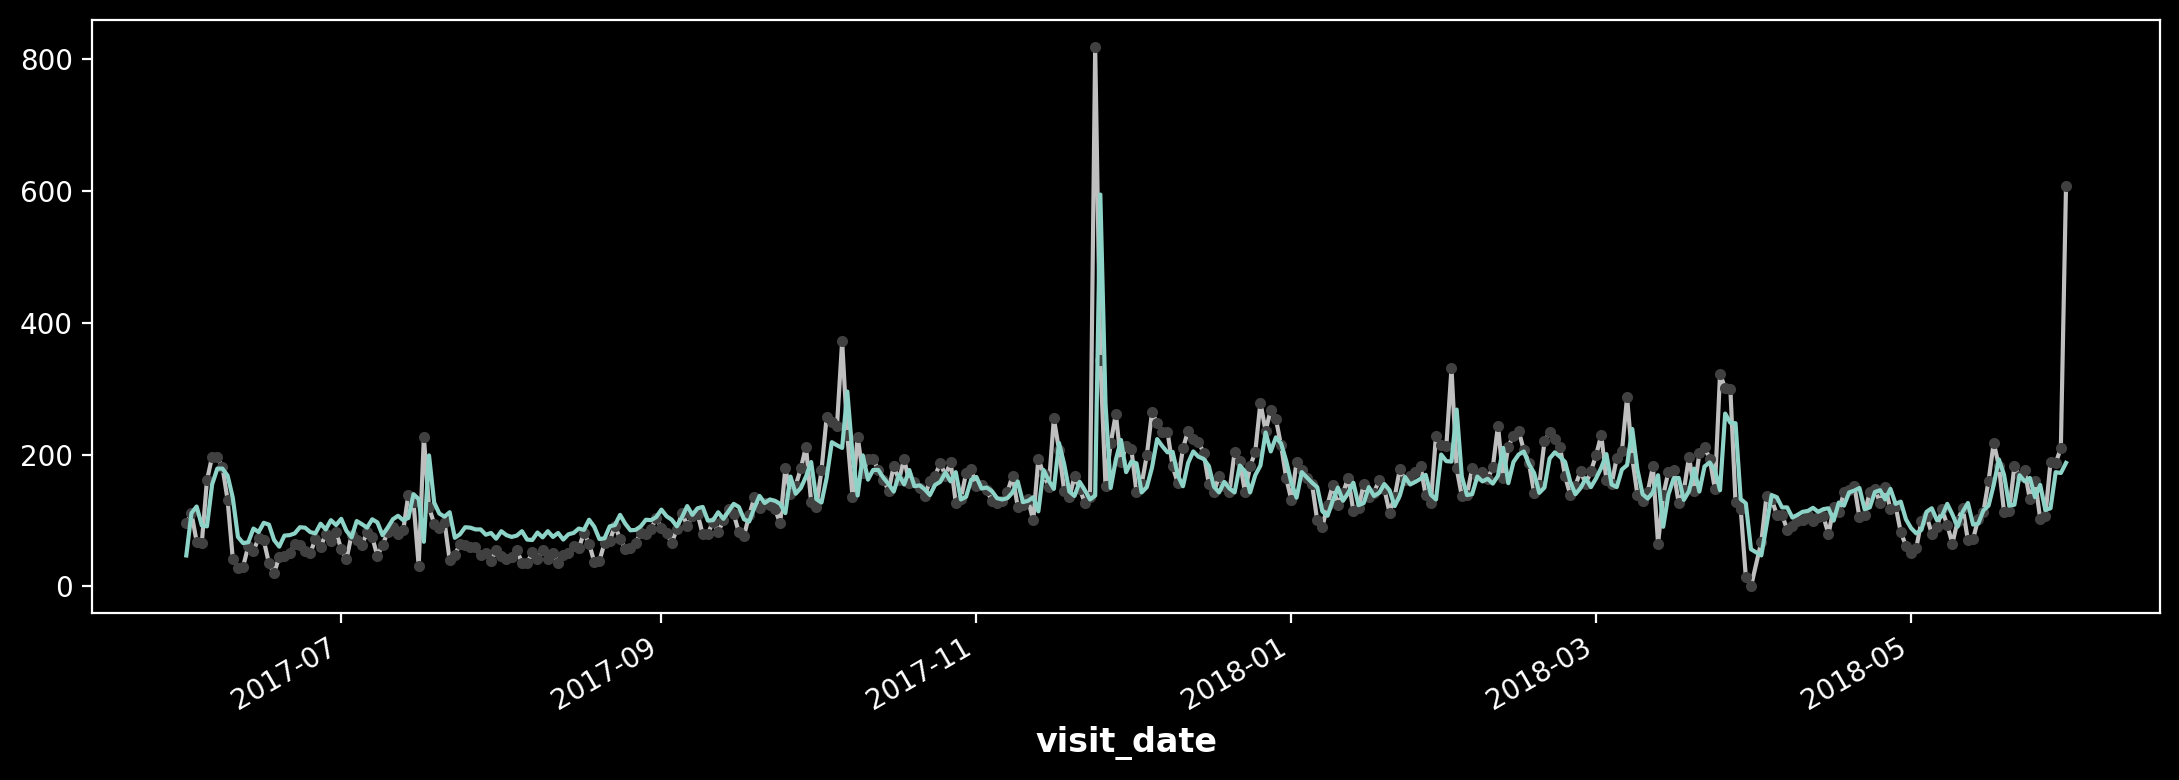

In [102]:
ax = y2_orders.plot(**plot_params)
ax = y_pred2_orders.plot()

## Trend

Creating in accodings with the Kaggle tutorial:

https://www.kaggle.com/code/ryanholbrook/trend

`Moving Average Plots`

The idea of mooving average is to smooth out any short-term fluctuations in the series so that only long-term changes remain.

For the DAU and Order series, we chose a window of size 30 to smooth over the monthly period within 12 months.

In [103]:
df_dau['moving_avg_30d_dau'] = df_dau['dau'].rolling(
    window=30 # 7 days window
    ,center=True # put the average at the center of the window
    ,min_periods=30
).mean()

df_dau['moving_avg_30d_orders'] = df_dau['orders'].rolling(
    window=30 # 7 days window
    ,center=True # put the average at the center of the window
    ,min_periods=30
).mean()


In [104]:
df_dau.sample(5)

,time,dau,orders,lag_dau,lag_orders,moving_avg_30d_dau,moving_avg_30d_orders
visit_date,,,,,,,
2017-10-02,123,1171,176,867,120,1013.966667,171.066667
2018-03-05,277,1253,195,1062,155,1126.566667,175.000000
2018-04-02,304,652,68,1,0,960.600000,136.766667
2018-05-28,360,1067,189,635,107,NaN,NaN
2017-11-24,176,3410,819,1456,136,1419.500000,206.533333


<Axes: title={'center': 'DAU (Daily Active Users) - 30 days Moving Average'}, xlabel='visit_date'>

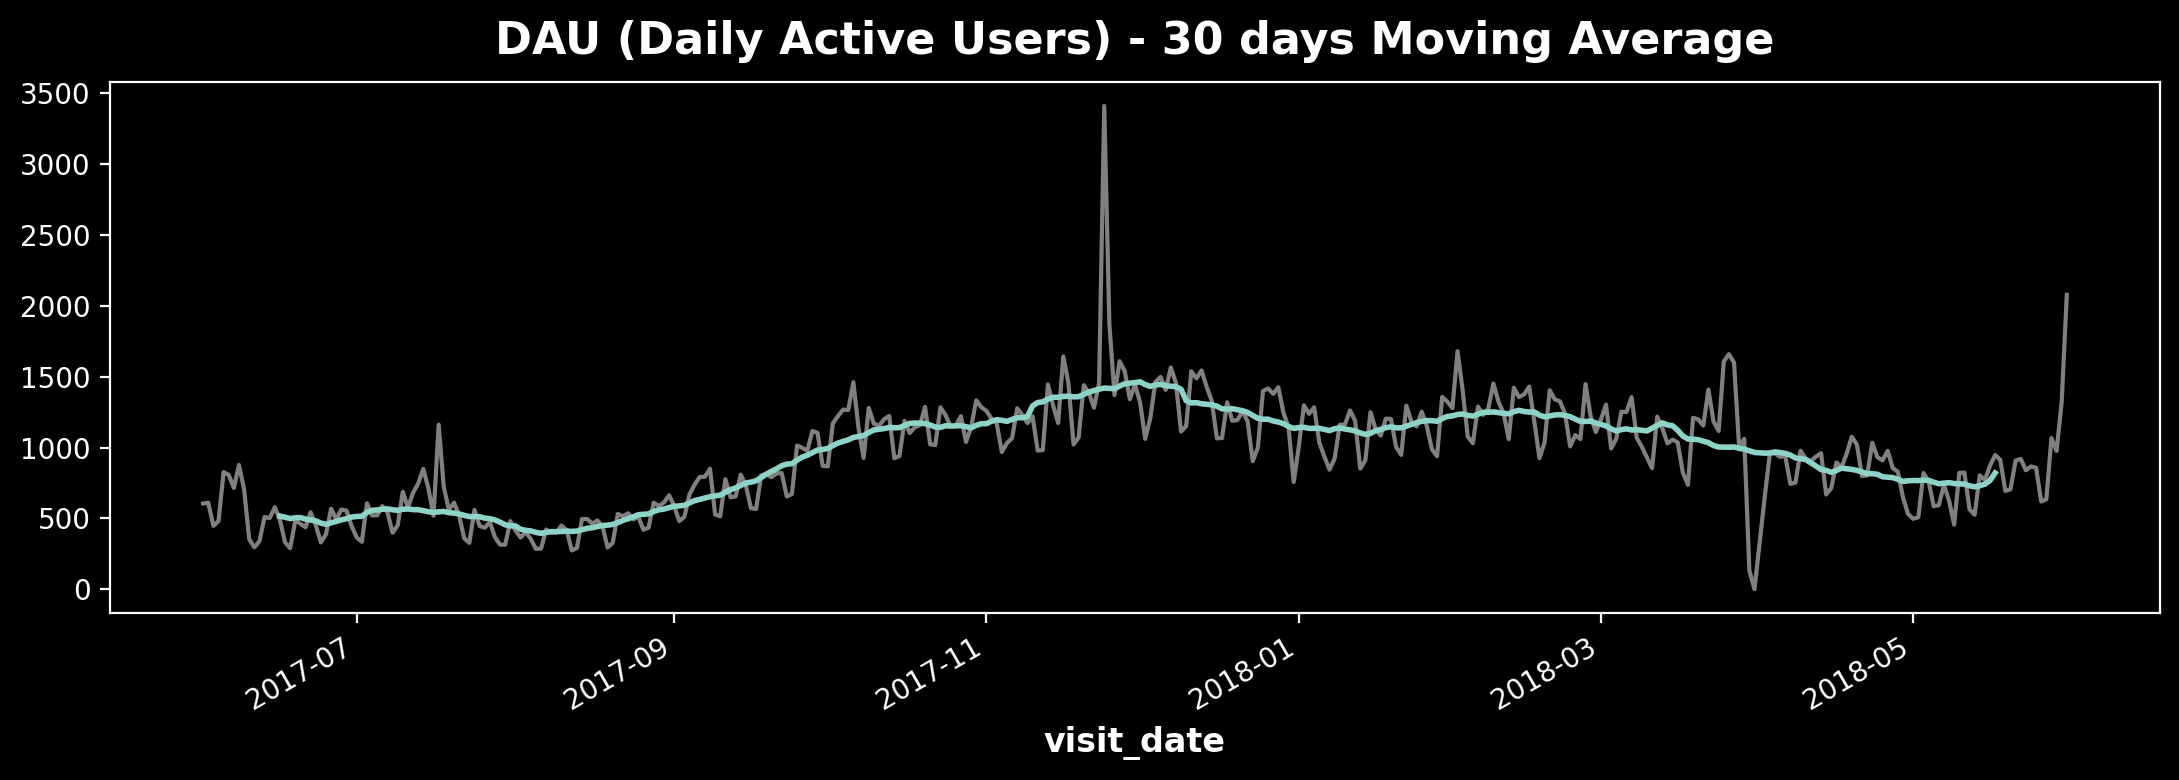

In [105]:
ax = df_dau['dau'].plot(style='', color='0.5')
df_dau['moving_avg_30d_dau'].plot(
    ax=ax
    ,linewidth=2
    ,title='DAU (Daily Active Users) - 30 days Moving Average'
    ,legend=False
)

<Axes: title={'center': 'Numbers of Orders - 30 days Moving Average'}, xlabel='visit_date'>

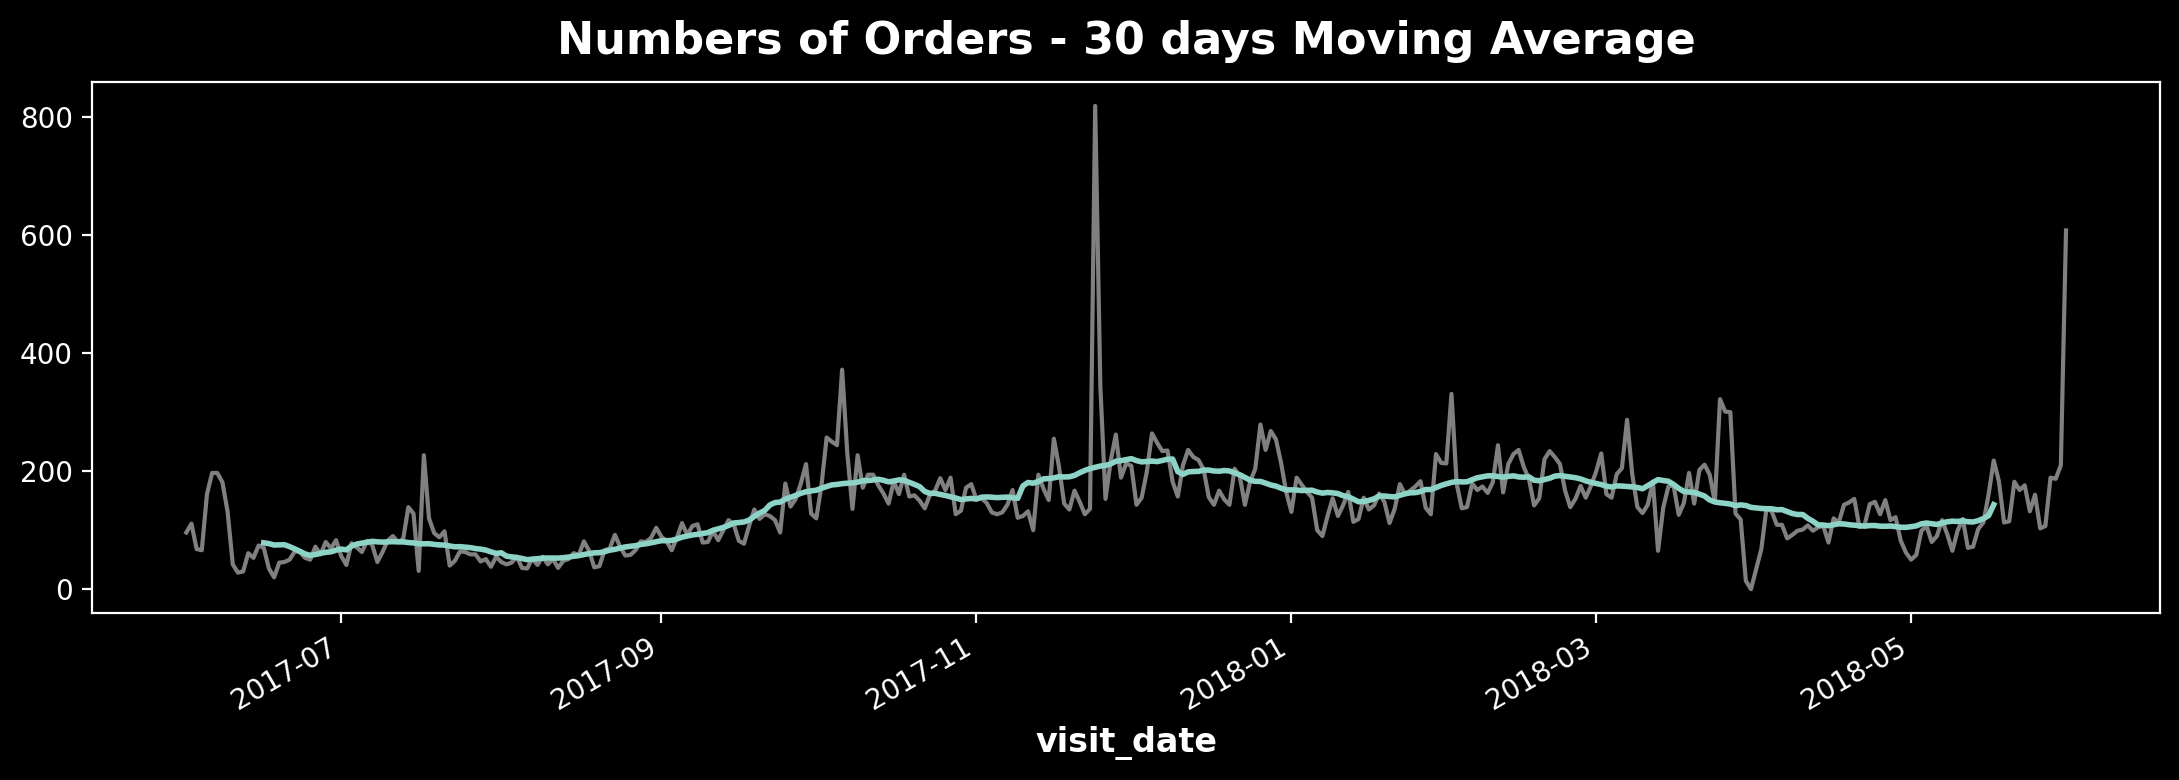

In [106]:
ax = df_dau['orders'].plot(style='', color='0.5')
df_dau['moving_avg_30d_orders'].plot(
    ax=ax
    ,linewidth=2
    ,title='Numbers of Orders - 30 days Moving Average'
    ,legend=False
)

In [107]:
_dau = df_dau[['dau']]
_dau.head()

,dau
visit_date,
2017-06-01,605
2017-06-02,611
2017-06-03,447
2017-06-04,481
2017-06-05,827


In [113]:
# tt = TimeTrend(constant=True)
four = Fourier(period=365.25, order=2)

dp = DeterministicProcess(
    index=_dau.index
    ,constant=True # dummy feature for the bias (y_intercept)
    ,order=1 # the time dummy (trend)
    # ,drop=True # drop terms if necessary to avoid collinearity
    # ,additional_terms=[four]
)

# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()
X_fore = dp.out_of_sample(steps=28)

X.head()
X_fore.head()

d:\ProgramData\Anaconda3\envs\tableau_env\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


,const,trend
visit_date,,
2017-06-01,1.0,1.0
2017-06-02,1.0,2.0
2017-06-03,1.0,3.0
2017-06-04,1.0,4.0
2017-06-05,1.0,5.0


,const,trend
365,1.0,365.0
366,1.0,366.0
367,1.0,367.0
368,1.0,368.0
369,1.0,369.0


In [115]:
y = _dau['dau'] # the target

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.

model = LinearRegression(fit_intercept=False)
model.fit(X, y)

LinearRegression(fit_intercept=False)

The trend discovered by our LinearRegression model is almost identical to the moving average plot, which suggests that a linear trend was the right decision in this case.

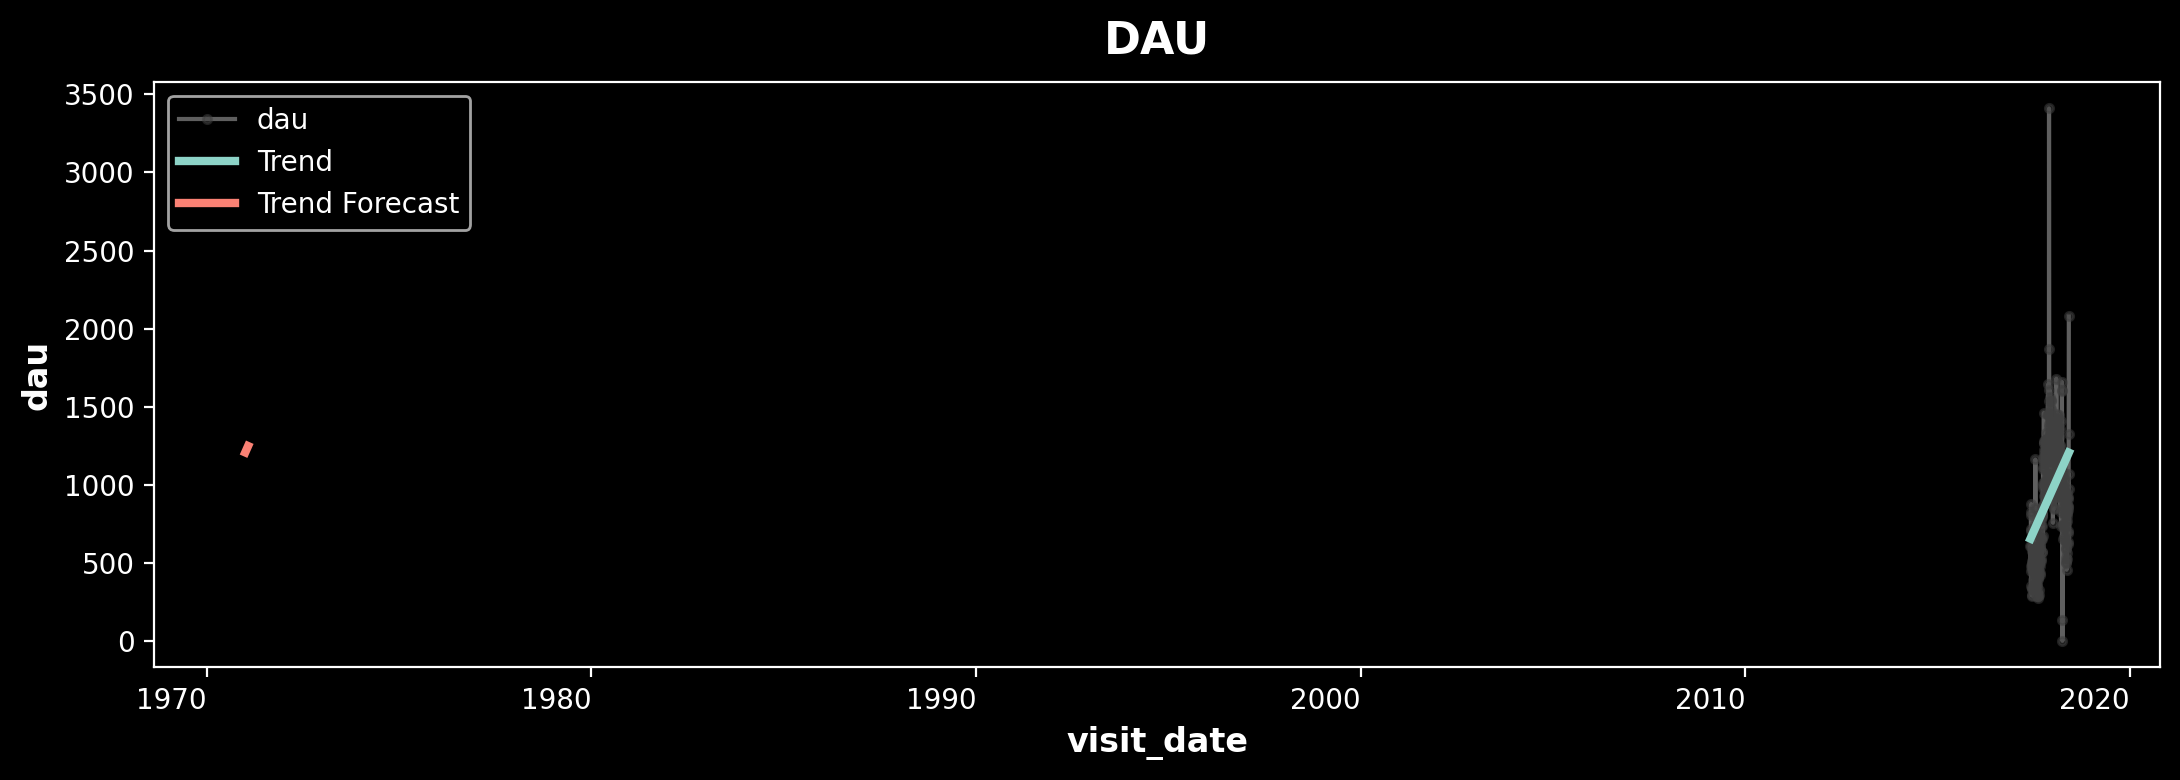

In [116]:
y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(**plot_params, alpha=0.5, title='DAU', ylabel="dau")
ax = y_pred.plot(ax=ax, linewidth=3, label='Trend', color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label='Trend Forecast', color='C3')
ax.legend()

# End